In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chi2





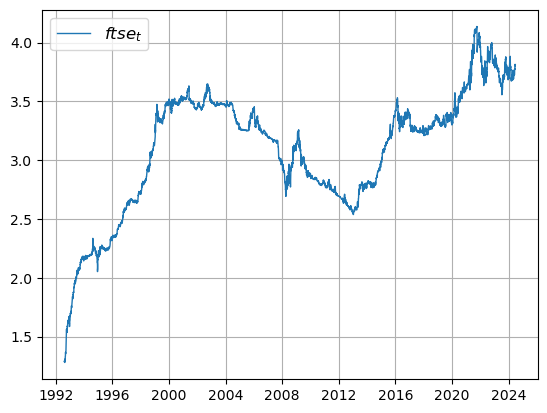

In [43]:
# Upload Data
dbUSDPEN = pd.read_excel('/Users/lucassalamanca/Downloads/codes_garch/tipodecambio.xlsx', sheet_name='USDPEN')

# Graph
plt.figure(1)
plt.plot(dbUSDPEN['DATE'], dbUSDPEN['PX_LAST'], linewidth=1)
plt.grid(True)
plt.legend(['$ftse_t$'], fontsize=12)
plt.show()


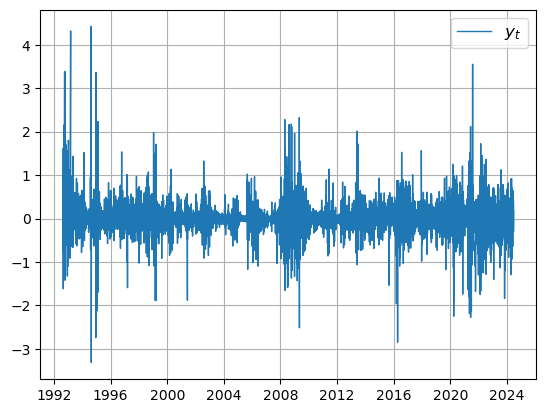

In [44]:
# Calculate log-returns
y = 100 * np.diff(np.log(dbUSDPEN['PX_LAST']))

# Create dates vector
fechas = dbUSDPEN['DATE'][1:]

# Graph
plt.figure(2)
plt.plot(fechas, y, linewidth=1)
plt.grid(True)
plt.legend(['$y_t$'], fontsize=12)
plt.show()


In [45]:
# ADF unit test root 
adf_result = adfuller(y)
print('Resultados de la Prueba ADF:')
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')
print('Valores críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Resultados de la Prueba ADF:
Estadístico ADF: -15.578131270261286
Valor p: 1.948060266448851e-28
Valores críticos:
   1%: -3.4311823498131093
   5%: -2.8619078380701954
   10%: -2.566965795575087


In [46]:
# Estimation GJR-GARCH(1,1) 

model_1 = arch_model(e, vol='Garch', p=1, o=1, q=1)
result_1 = model_1.fit(update_freq=0, disp='off')
print(result_1.summary())

# Log-likelihood GJR-GARCH(1,1)
loglik_1 = result_1.loglikelihood

# Estimated parameters GJR-GARCH(1,1)
params_1 = result_1.params
omega_1 = params_1['omega']
alpha_1 = params_1['alpha[1]']
gamma_1 = params_1['gamma[1]']
beta_1 = params_1['beta[1]']

print('The p-value of gamma is less than 0.05, therefore the leverage parameter is significant')

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -462.309
Distribution:                  Normal   AIC:                           934.617
Method:            Maximum Likelihood   BIC:                           969.478
                                        No. Observations:                 7881
Date:                Mon, Aug 26 2024   Df Residuals:                     7880
Time:                        22:49:43   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0142  2.262e-03     -6.257  3.928e-

In this model, the gamma coefficient is negative, indicating that a depreciation of the Peruvian Sol—reflected by a higher USD/PEN ratio—generates a larger impact on the volatility of returns.

In [47]:
# Estimation GARCH (1,1)

model_2 = arch_model(e, vol='Garch', p=1, o=0, q=1)
result_2 = model_2.fit(update_freq=0, disp='off')
print(result_2.summary())

# Log-likelihood GARCH (1,1)
loglik_2 = result_2.loglikelihood

# Estimated parameters GARCH (1,1)
params_2 = result_2.params
omega_2 = params_2['omega']
alpha_2 = params_2['alpha[1]']
beta_2 = params_2['beta[1]']

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -490.816
Distribution:                  Normal   AIC:                           989.633
Method:            Maximum Likelihood   BIC:                           1017.52
                                        No. Observations:                 7881
Date:                Mon, Aug 26 2024   Df Residuals:                     7880
Time:                        22:49:47   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0162  2.520e-03     -6.436  1.229e-

Likelihood Ratio Test

In [48]:
#Likelihood ratio test
LR_stat = -2 * (loglik_2 - loglik_1)
p_value = chi2.sf(LR_stat, 1)  # Degrees of freedom = 1, we are comparing a model with an extra parameter

print(f'Likelihood Ratio Statistic: {LR_stat:.4f}')
print(f'P-value: {p_value:.4f}')
print("As seen from the LRT, the inclusion of the gamma term in the GJR-GARCH(1,1) model significantly improves the model's fit to the data.")

Likelihood Ratio Statistic: 57.0154
P-value: 0.0000
As seen from the LRT, the inclusion of the gamma term in the GJR-GARCH(1,1) model significantly improves the model's fit to the data.


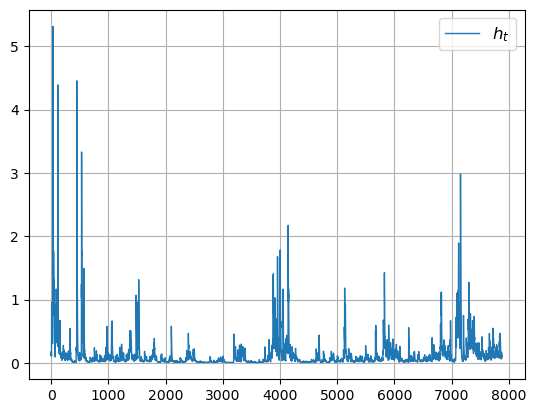

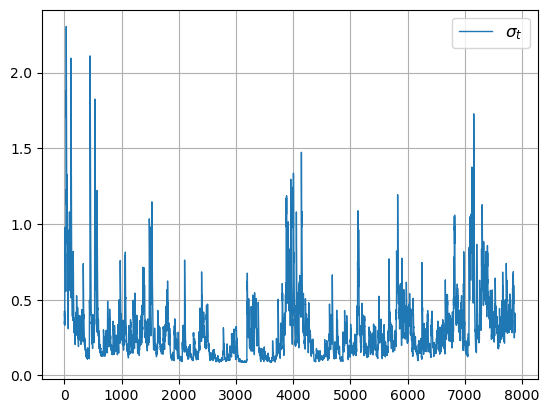

In [49]:
# Calculation of the conditional variance of the estimated parameters 
h = np.full_like(e, np.nan)
h[0] = np.var(y)
for t in range(1, len(e)):
    h[t] = omega_1 + alpha_1 * e[t-1]**2 + gamma_1 * (e[t-1]**2) * (e[t-1] < 0) + beta_1 * h[t-1]

# Graph of the unconditional variance 
plt.figure(3)
plt.plot(range(1, len(e) + 1), h, linewidth=1)
plt.grid(True)
plt.legend(['$h_t$'], fontsize=12)
plt.show()

# Graph of the volatility
plt.figure(4)
plt.plot(range(1, len(e) + 1), np.sqrt(h), linewidth=1)
plt.grid(True)
plt.legend(['$\sigma_t$'], fontsize=12)
plt.show()


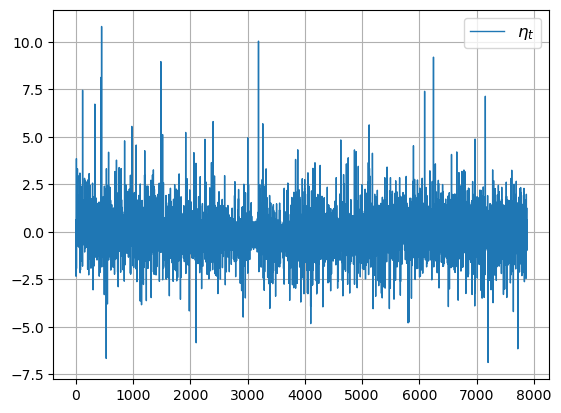

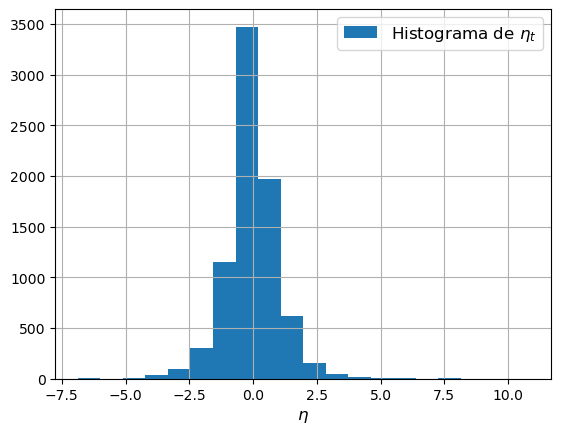

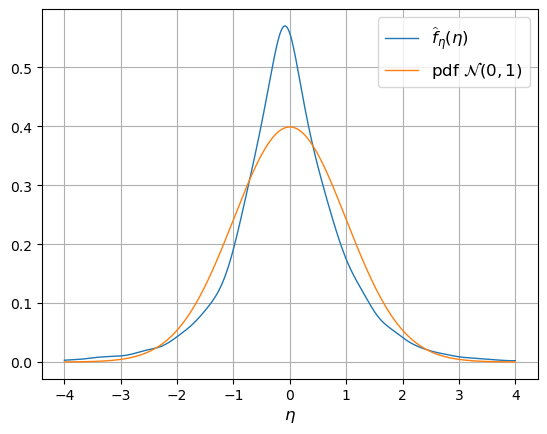

In [50]:
# Calculation of the standardize innovations 

# Standardized innovations
eta = e / np.sqrt(h)

# Graph of standardized innovations
plt.figure(5)
plt.plot(range(1, len(e) + 1), eta, linewidth=1)
plt.grid(True)
plt.legend(['$\eta_t$'], fontsize=12)
plt.show()

# Histogram
plt.figure(6)
plt.hist(eta, bins=20)
plt.grid(True)
plt.xlabel('$\eta$', fontsize=12)
plt.legend(['Histograma de $\eta_t$'], fontsize=12)
plt.show()

# Eta's sample density compared to the standard normal density  
plt.figure(7)
etasample = np.linspace(-4, 4, 800)
kde = gaussian_kde(eta)
samplepdf = kde(etasample)
normalpdf = norm.pdf(etasample, 0, 1)
plt.plot(etasample, samplepdf, linewidth=1)
plt.plot(etasample, normalpdf, linewidth=1)
plt.xlabel('$\eta$', fontsize=12)
plt.legend(['$\widehat{f}_{\eta}(\eta)$', 'pdf $\mathcal{N}(0,1)$'], fontsize=12)
plt.grid(True)
plt.show()